In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-33hf12pi
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-33hf12pi
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.6 MB/s eta 0:00:00
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33806 sha256=d48e3aca371277579f368119f7976948891d9e10647ff9bc8a497f82dbe43e0d
  Stored in directory: /tmp/pip-ephem-wheel-cache-p0gxeihs/wheels/ce/d6/f1/5d00e82b3893c5f1ffee43bf7b8877148af09c7c9c6c4882c9
Successfully built segmentation-models


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Add, Multiply, Reshape, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
import tensorflow.keras.backend as K
import numpy as np
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt

In [6]:
def resnet(num_classes):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(num_classes, activation='relu')(x)

    model = Model(inputs=base_model.input, outputs=output)

    for layer in base_model.layers:
        layer.trainable = False

    return model

In [7]:
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [8]:
# Load data
x_train = np.load('/content/drive/MyDrive/np_images/x_train.npy')
y_train = np.load('/content/drive/MyDrive/np_images/y_train.npy')
x_test = np.load('/content/drive/MyDrive/np_images/x_test.npy')
y_test = np.load('/content/drive/MyDrive/np_images/y_test.npy')

In [9]:
# Augmentation
from keras.preprocessing.image import ImageDataGenerator

def preprocess_image(img):
    # Crop the center 80% of the image
    height, width, channels = img.shape
    crop_height = int(height * 0.8)
    crop_width = int(width * 0.8)
    start_height = int((height - crop_height) / 2)
    start_width = int((width - crop_width) / 2)
    img = img[start_height:start_height+crop_height, start_width:start_width+crop_width, :]
    
    # Apply Gaussian blur with kernel size 3
    img = cv2.GaussianBlur(img, (3, 3), 0)

    img = cv2.resize(img,(224,224))
    
    # Rescale the pixel values to [0, 1]
    img = img / 255.0
    
    return img

def create_datagen():
    return ImageDataGenerator(
        horizontal_flip=True,   # randomly flip images
        vertical_flip=True,     # randomly flip images

        preprocessing_function = preprocess_image
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train,batch_size=32)
print("Image data augmentated ...")

Image data augmentated ...


In [10]:
# Preprocess data
x_train = tf.image.resize(x_train, size=(224, 224)) / 255.0
x_test = tf.image.resize(x_test, size=(224, 224)) / 255.0

# Split data into train and validation sets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(32)

# Create model
model = resnet(num_classes=5)
model.compile(loss='categorical_crossentropy', optimizer=AdamW(lr=0.0001), metrics=['accuracy',f1])

# Train model
history = model.fit(train_dataset, epochs=100, validation_data=test_dataset)

94765736/94765736 [==============================] - 5s 0us/step


Epoch 1/100
92/92 [==============================] - 28s 160ms/step - loss: 3.0071 - accuracy: 0.4940 - f1: 0.3296 - val_loss: 3.0335 - val_accuracy: 0.4789 - val_f1: 0.3341
Epoch 2/100
92/92 [==============================] - 11s 119ms/step - loss: 2.9438 - accuracy: 0.4964 - f1: 0.3355 - val_loss: 3.0274 - val_accuracy: 0.4789 - val_f1: 0.3322
Epoch 3/100
92/92 [==============================] - 12s 127ms/step - loss: 2.9369 - accuracy: 0.4964 - f1: 0.3371 - val_loss: 3.0358 - val_accuracy: 0.4789 - val_f1: 0.3359
Epoch 4/100
92/92 [==============================] - 11s 121ms/step - loss: 2.9362 - accuracy: 0.4964 - f1: 0.3381 - val_loss: 3.0206 - val_accuracy: 0.4789 - val_f1: 0.3411
Epoch 5/100
92/92 [==============================] - 11s 125ms/step - loss: 2.9337 - accuracy: 0.4964 - f1: 0.3401 - val_loss: 3.0063 - val_accuracy: 0.4789 - val_f1: 0.3396
Epoch 6/100
92/92 [==============================] - 12s 129ms/step - loss: 2.9219 - accuracy: 0.4964 - f1: 0.3434 - val_loss: 2.9

In [11]:
# Evaluate model on test set
test_loss,test_acc,f1_score = model.evaluate(test_dataset)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('F1 Score:', f1_score)

23/23 [==============================] - 2s 98ms/step - loss: nan - accuracy: 0.4789 - f1: 0.0000e+00
Test loss: nan
Test accuracy: 0.4788540303707123
F1 Score: 0.0


In [21]:
history.history

{'loss': [3.0070676803588867,
  2.9438042640686035,
  2.9368796348571777,
  2.9362244606018066,
  2.933742046356201,
  2.9218690395355225,
  2.8929238319396973,
  2.972212076187134,
  2.916992425918579,
  2.9036059379577637,
  2.8823156356811523,
  2.8516902923583984,
  2.8468711376190186,
  2.806576728820801,
  2.837421417236328,
  2.886331558227539,
  2.923525333404541,
  2.906954526901245,
  2.886939525604248,
  2.8650996685028076,
  2.81941294670105,
  2.8381335735321045,
  2.8121206760406494,
  2.883124828338623,
  2.779897451400757,
  2.8211634159088135,
  2.8076860904693604,
  2.77573823928833,
  2.8082833290100098,
  2.859203338623047,
  2.8975725173950195,
  2.866363525390625,
  2.8211207389831543,
  2.783151865005493,
  2.795178174972534,
  2.8351645469665527,
  2.7811758518218994,
  2.8893942832946777,
  2.784707546234131,
  2.7798383235931396,
  2.7516679763793945,
  2.9319591522216797,
  2.857558012008667,
  2.8175048828125,
  2.8094749450683594,
  2.786916732788086,
  2.7

In [22]:
training_loss = history.history['loss']
training_loss

[3.0070676803588867,
 2.9438042640686035,
 2.9368796348571777,
 2.9362244606018066,
 2.933742046356201,
 2.9218690395355225,
 2.8929238319396973,
 2.972212076187134,
 2.916992425918579,
 2.9036059379577637,
 2.8823156356811523,
 2.8516902923583984,
 2.8468711376190186,
 2.806576728820801,
 2.837421417236328,
 2.886331558227539,
 2.923525333404541,
 2.906954526901245,
 2.886939525604248,
 2.8650996685028076,
 2.81941294670105,
 2.8381335735321045,
 2.8121206760406494,
 2.883124828338623,
 2.779897451400757,
 2.8211634159088135,
 2.8076860904693604,
 2.77573823928833,
 2.8082833290100098,
 2.859203338623047,
 2.8975725173950195,
 2.866363525390625,
 2.8211207389831543,
 2.783151865005493,
 2.795178174972534,
 2.8351645469665527,
 2.7811758518218994,
 2.8893942832946777,
 2.784707546234131,
 2.7798383235931396,
 2.7516679763793945,
 2.9319591522216797,
 2.857558012008667,
 2.8175048828125,
 2.8094749450683594,
 2.786916732788086,
 2.7999956607818604,
 2.754732370376587,
 2.803337812423706

In [23]:
import pandas as pd
hist_df = pd.DataFrame(history.history)

hist_csv_file = "/content/drive/MyDrive/Resnet50/resnet_history.csv"
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [24]:
model.save('/content/drive/MyDrive/Resnet50/resnet_model.h5')

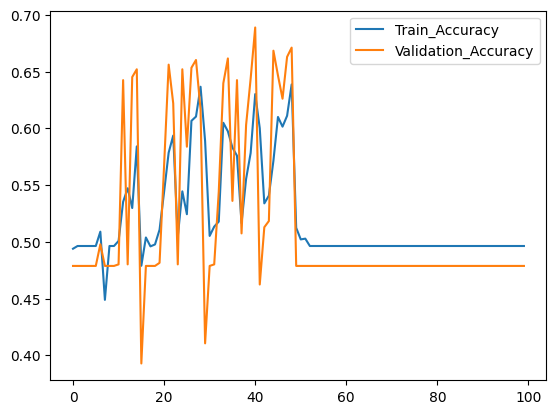

In [25]:
# Plotting graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train_Accuracy','Validation_Accuracy'])

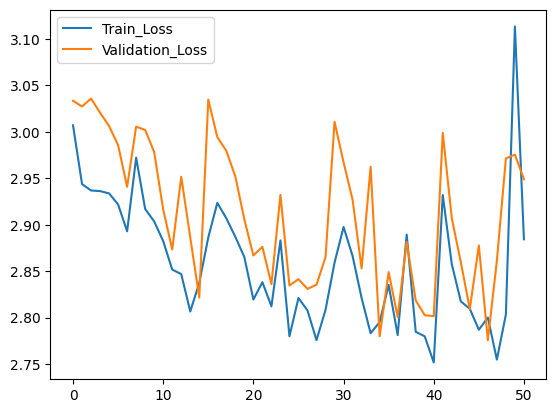

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train_Loss','Validation_Loss'])

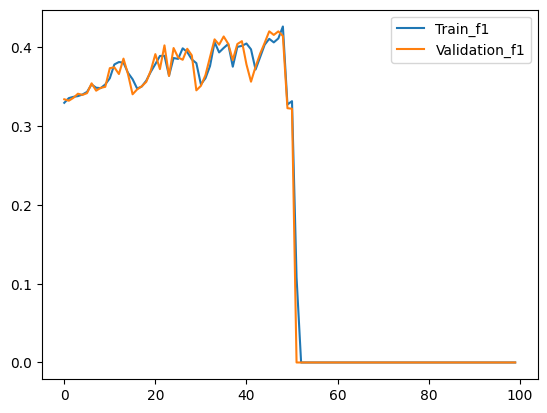

In [27]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.legend(['Train_f1','Validation_f1'])

In [28]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis = 1)
pred.shape

import numpy as np

# Convert multilabel-indicator targets to multiclass labels
y_test = np.argmax(y_test, axis=1)

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(pred, y_test)
print(cf_matrix)


23/23 [==============================] - 2s 94ms/step


AxisError: ignored

<Axes: >

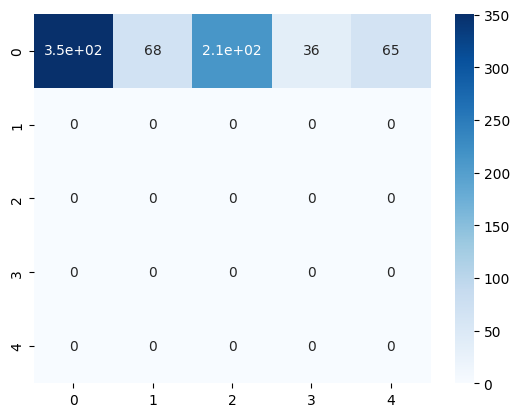

In [29]:
import seaborn as sns
sns.heatmap(cf_matrix, cmap='Blues', annot=True)